# Speech Emotion Recognition prediction with RAVDESS dataset

In [1]:
from keras import Sequential
import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import  seaborn as sns
import librosa
from sklearn.preprocessing import StandardScaler
import os
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import numpy as np
from keras.utils import to_categorical
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
import joblib
from sklearn.utils import shuffle

# Import RAVDESS Datatset

In [2]:
# CREATE DIRECTORY OF AUDIO FILES
audio = 'C:/Users/tahar/Documents/emotions_predict_project/audio/audio_speech_actors_01-24/'
actor_folders = os.listdir(audio) #list files in audio directory
actor_folders[0:5]

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05']

In [3]:
# CREATE FUNCTION TO EXTRACT EMOTION NUMBER, ACTOR AND GENDER LABEL
emotion = []
gender = []
file_path = []
# Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:
for i in actor_folders:
    filename = os.listdir(audio + i) #iterate over Actor folders
    for f in filename: # go through files in Actor folder
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2])) # Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
        bg = int(part[6])
        if bg%2 == 0:
            bg = "female"
        else:
            bg = "male"
        gender.append(bg) # Odd numbered actors are male, even numbered actors are female
        file_path.append(audio + i + '/' + f)

In [4]:
# PUT EXTRACTED LABELS WITH FILEPATH INTO DATAFRAME
df = pd.DataFrame(emotion)
df = df.replace({1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'})
df = pd.concat([pd.DataFrame(gender), df], axis=1)
df.columns = ['gender', 'emotion']
df = pd.concat([df, pd.DataFrame(file_path, columns = ['path'])], axis=1)
df

,gender,emotion,path
0,male,neutral,C:/Users/tahar/Documents/emotions_predict_proj...
1,male,neutral,C:/Users/tahar/Documents/emotions_predict_proj...
2,male,neutral,C:/Users/tahar/Documents/emotions_predict_proj...
3,male,neutral,C:/Users/tahar/Documents/emotions_predict_proj...
4,male,calm,C:/Users/tahar/Documents/emotions_predict_proj...
...,...,...,...
1435,female,surprise,C:/Users/tahar/Documents/emotions_predict_proj...
1436,female,surprise,C:/Users/tahar/Documents/emotions_predict_proj...
1437,female,surprise,C:/Users/tahar/Documents/emotions_predict_proj...
1438,female,surprise,C:/Users/tahar/Documents/emotions_predict_proj...


# Data preprocessing

In [5]:
# Function to extract MFCC features
def extract_features(file_path):
    audio, sr = librosa.load(file_path)
    mfcc= librosa.feature.mfcc(y=audio, sr=sr)
    return mfcc.T

In [6]:
# Apply the function to extract features
features = df['path'].apply(extract_features)

# Create an empty list to store the aggregated MFCC features
mfcc_data = []

# Compute aggregated statistics for each MFCC feature
for i, feature in enumerate(features):
    # Compute statistics (mean, standard deviation, and maximum) along the rows (frames)
    mfcc_stats = np.hstack((np.mean(feature, axis=0), np.std(feature, axis=0), np.max(feature, axis=0)))

    # Create a dictionary with the aggregated statistics
    mfcc_dict = {f'mfcc{j}_mean': mfcc_stats[j] for j in range(mfcc_stats.shape[0]//3)}
    mfcc_dict.update({f'mfcc{j}_std': mfcc_stats[j + mfcc_stats.shape[0]//3] for j in range(mfcc_stats.shape[0]//3)})
    mfcc_dict.update({f'mfcc{j}_max': mfcc_stats[j + 2*mfcc_stats.shape[0]//3] for j in range(mfcc_stats.shape[0]//3)})

    # Append the dictionary to the list
    mfcc_data.append(mfcc_dict)

# Convert the list of dictionaries to a DataFrame
mfcc_df = pd.DataFrame.from_records(mfcc_data)

# Concatenate the original DataFrame with the aggregated MFCC DataFrame
df = pd.concat([df, mfcc_df], axis=1)
df.drop(columns='path', inplace=True)
df.head()

,gender,emotion,mfcc0_mean,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,...,mfcc10_max,mfcc11_max,mfcc12_max,mfcc13_max,mfcc14_max,mfcc15_max,mfcc16_max,mfcc17_max,mfcc18_max,mfcc19_max
0,male,neutral,-697.792603,54.890041,0.663466,12.435786,7.733952,0.530750,-3.216631,-3.159395,...,19.282513,13.166721,42.405159,6.360347,17.785788,10.016875,7.932010,10.800980,9.970127,6.679748
1,male,neutral,-692.855774,55.363899,-1.548319,16.038307,8.818810,-0.146587,-1.373392,-5.293180,...,20.866905,13.476914,39.858543,9.668144,24.269985,12.586897,10.210186,13.390223,10.713772,10.956112
2,male,neutral,-691.587891,58.024662,0.159465,13.624650,5.374112,1.162336,-2.083359,-5.382585,...,20.811386,14.159821,46.281670,5.885535,17.851379,14.784107,4.818031,4.499362,13.342928,10.096229
3,male,neutral,-685.105469,55.879421,2.783262,13.252023,6.989668,2.981274,-1.586029,-6.961661,...,21.657051,15.068411,27.479233,20.469234,10.382744,15.994092,15.000591,7.484988,11.135729,8.726198
4,male,calm,-727.104370,62.355034,3.121181,15.064671,8.132434,1.927084,-3.274656,-3.761792,...,28.543127,9.657723,30.568981,8.716321,14.647698,15.242265,7.977610,14.077288,9.820648,9.831396


In [7]:
df = shuffle(df, random_state=25).reset_index(drop=True)
# EXPORT TO CSV
df.to_csv('audio.csv', index=False)
df.head()

,gender,emotion,mfcc0_mean,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,...,mfcc10_max,mfcc11_max,mfcc12_max,mfcc13_max,mfcc14_max,mfcc15_max,mfcc16_max,mfcc17_max,mfcc18_max,mfcc19_max
0,female,neutral,-598.682068,51.607494,10.780660,13.437082,5.478275,0.050055,-4.452174,-8.553011,...,16.955715,11.347542,17.713367,16.274487,13.036097,26.060524,17.492521,11.138642,24.170418,5.117128
1,male,neutral,-615.366272,55.919556,3.157600,11.845134,6.671293,1.060359,-15.418916,-7.866930,...,26.074591,19.516325,22.964466,7.113430,5.223763,17.097385,19.158764,11.243517,22.436916,9.491608
2,female,neutral,-687.891602,52.303005,1.630500,0.838483,4.323021,-1.807789,-8.304306,-10.773336,...,13.733820,12.739329,29.632713,23.600800,15.405669,8.295467,11.834898,6.945889,11.120144,8.980192
3,male,angry,-617.416504,75.535324,6.918883,9.337250,8.847603,-7.298743,-0.068879,-6.846485,...,23.601683,22.158028,33.018787,18.687664,12.293322,13.371948,15.862774,17.931416,10.513776,15.314692
4,male,surprise,-676.915466,46.510468,0.211802,6.522935,-1.068617,1.553112,-6.250492,-5.513490,...,19.556515,15.540763,20.700806,17.268517,7.304035,8.691813,6.756019,11.509393,14.219808,18.917543


In [8]:
# check if dataset is balanced
Counter(df.loc[:,'emotion'])

Counter({'angry': 192,
         'surprise': 192,
         'sad': 192,
         'calm': 192,
         'disgust': 192,
         'fear': 192,
         'happy': 192,
         'neutral': 96})

In [9]:
df.isnull().sum()

gender        0
emotion       0
mfcc0_mean    0
mfcc1_mean    0
mfcc2_mean    0
             ..
mfcc15_max    0
mfcc16_max    0
mfcc17_max    0
mfcc18_max    0
mfcc19_max    0
Length: 62, dtype: int64

In [10]:
x= df.drop('emotion', axis=1)
y=df.loc[ : ,'emotion']
x['gender'].replace({'male':1,'female':0},inplace=True)
lb= LabelEncoder()
y_encoded = lb.fit_transform(y)
joblib.dump(lb,'encoder.pkl')

['encoder.pkl']

In [11]:
smote = SMOTE(sampling_strategy='minority') # use smote technique to bump up our minority class in this case neutral class
X1, y = smote.fit_resample(x,y_encoded)
Standard_Scaler=StandardScaler()
x=Standard_Scaler.fit_transform(X1) # scale our features
joblib.dump(Standard_Scaler,'scaler.pkl')
Counter(y) # check again if our dataset get balanced

Counter({5: 192, 0: 192, 7: 192, 6: 192, 1: 192, 2: 192, 3: 192, 4: 192})

# Training models and comparing their performances

In [12]:
# split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [13]:
# Create an SVM classifier
svm_cv = SVC()
# Define an hyperparameter grid for the search
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'C': [0.1, 1, 10],
              'gamma': ['scale', 'auto']}

# Create a GridSearchCV object with 6-fold cross-validation to search for the best hyperparameters
grid_search = GridSearchCV(svm_cv, param_grid, cv=6)
# Apply the grid search on our data
grid_search.fit(x,y )
# Redefine the SVM classifier with the parameters obtained from the grid search
k=grid_search.best_params_['kernel']
g=grid_search.best_params_['gamma']
c=grid_search.best_params_['C']
svm_cv = SVC(kernel=k,gamma=g,C=c)
# Apply SVM on the data
svm_cv.fit(X_train,Y_train)

SVC(C=10, gamma='auto')

In [14]:
y_pred = svm_cv.predict(X_test)
joblib.dump(svm_cv,'emotion_predict_model.pkl')
accuracy= accuracy_score(Y_test,y_pred )
accuracy

0.814935064935065

In [15]:
# PREDICTIONS
predictions = lb.inverse_transform(y_pred)
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
actual = lb.inverse_transform(Y_test)
actual = pd.DataFrame({'Actual Values': actual})

# COMBINE BOTH
finaldf = actual.join(predictions)
finaldf[140:150]

,Actual Values,Predicted Values
140,fear,calm
141,neutral,neutral
142,angry,disgust
143,neutral,neutral
144,happy,disgust
145,surprise,surprise
146,sad,sad
147,surprise,sad
148,calm,calm
149,sad,sad


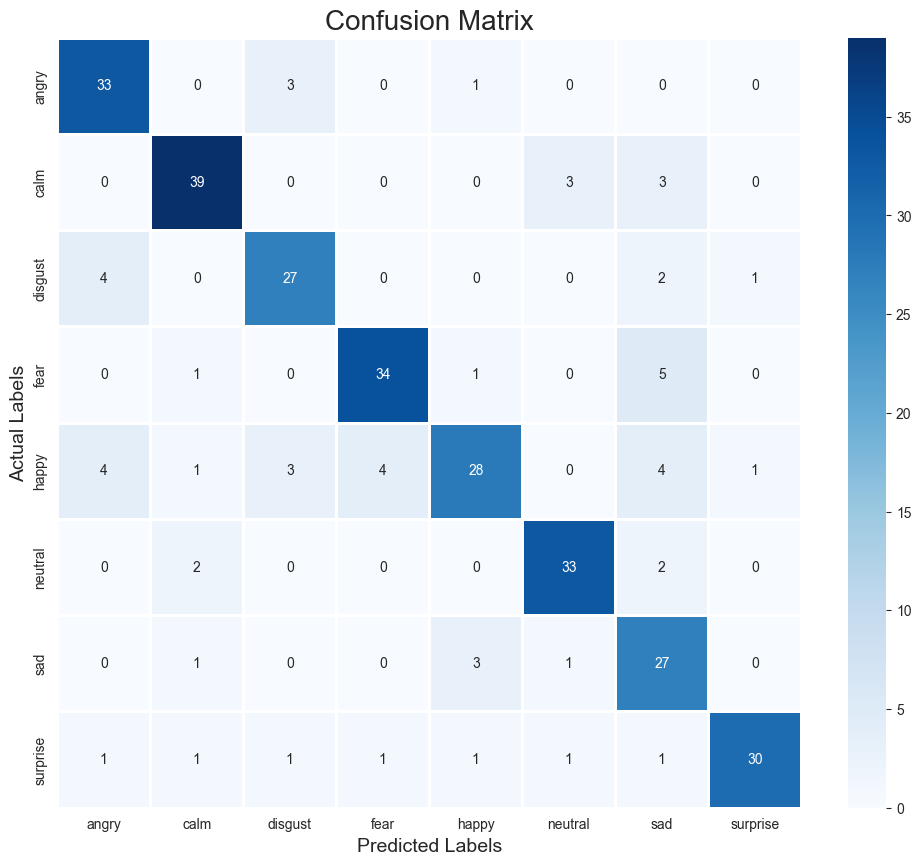

In [16]:
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION
cm = confusion_matrix(Y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in  lb.classes_ ] , columns = [i for i in lb.classes_ ])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [17]:
from keras.regularizers import l2
# Define a CNN model
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(256, kernel_size=3, activation='relu'))
model.add(Conv1D(256, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Y_train_encoded = to_categorical(Y_train)
Y_test_encoded = to_categorical(Y_test)
# Train the model
model.fit(X_train, Y_train_encoded, validation_data=(X_test, Y_test_encoded), batch_size=34, epochs=75, verbose=0)
# Evaluate the model
eval_model = model.evaluate(X_test, Y_test_encoded)
eval_model # got lower accuracy score than svm


10/10 [==============================] - 0s 5ms/step - loss: 1.3408 - accuracy: 0.7208


[1.3408293724060059, 0.7207792401313782]

In [18]:
# PREDICTIONS
y_pred = model.predict(X_test)
y_pred=y_pred.argmax(axis=1)
predictions = y_pred.astype(int).flatten()
predictions = lb.inverse_transform(predictions)
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
actual=Y_test
actual = lb.inverse_transform(actual)
actual = pd.DataFrame({'Actual Values': actual})

# COMBINE BOTH
finaldf = actual.join(predictions)
finaldf[140:150]

10/10 [==============================] - 0s 5ms/step


,Actual Values,Predicted Values
140,fear,disgust
141,neutral,calm
142,angry,disgust
143,neutral,neutral
144,happy,happy
145,surprise,surprise
146,sad,sad
147,surprise,sad
148,calm,calm
149,sad,sad


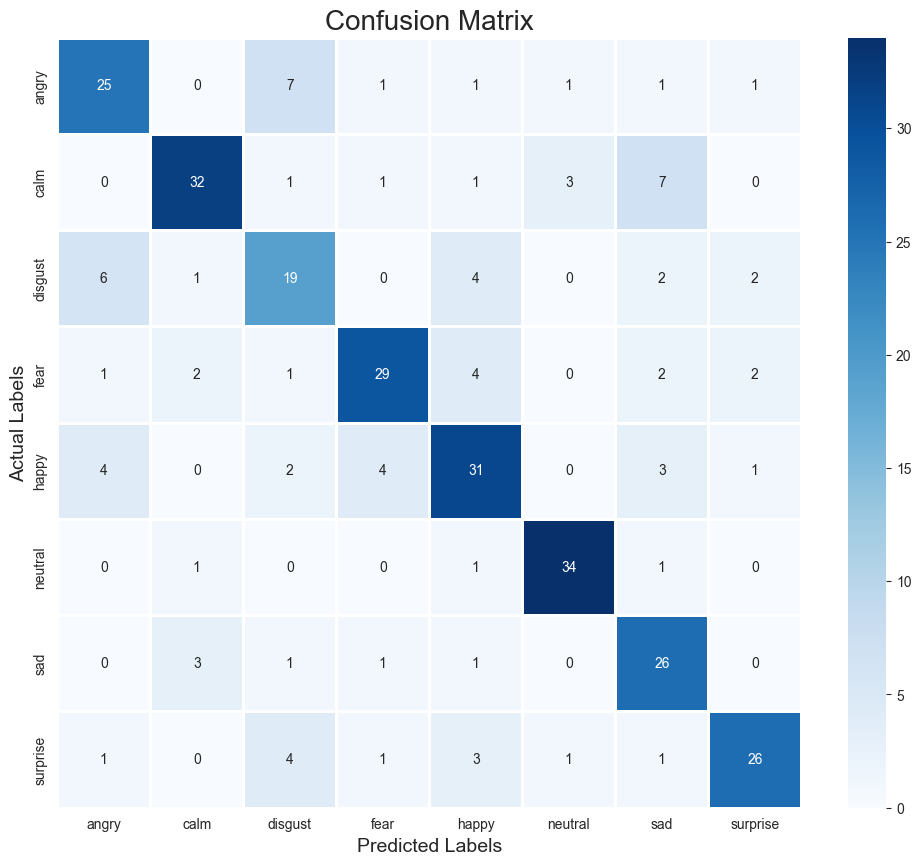

In [19]:
# CREATE CONFUSION MATRIX OF ACTUAL VS PREDICTION
cm = confusion_matrix(Y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in  lb.classes_ ] , columns = [i for i in lb.classes_ ])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

# Plot learning curve for both SVM and CNN models

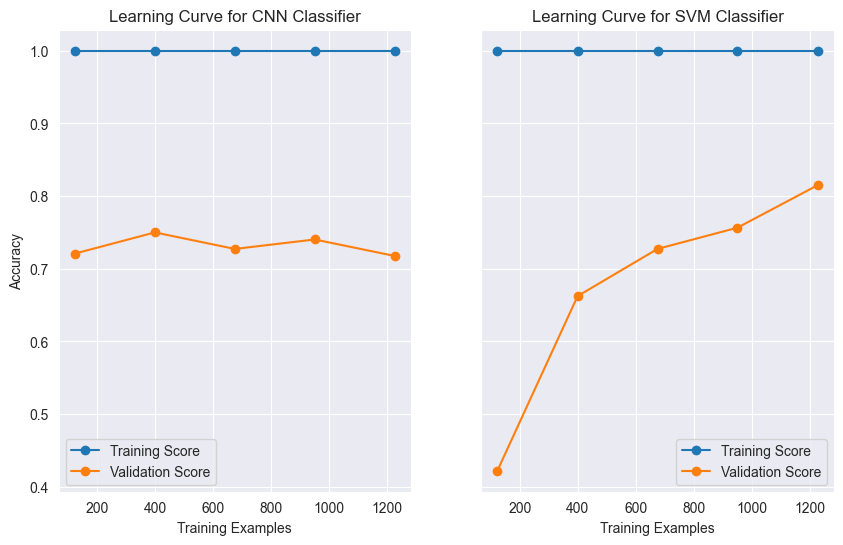

In [22]:
# display learning curve for SVM and CNN models
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)
train_sizes = np.linspace(0.1, 1.0, 5)
cnn_train_scores = []
cnn_test_scores = []
svm_train_scores = []
svm_test_scores = []
train_sizes = [ int(train_size * len(X_train)) for train_size in train_sizes]

for train_size in train_sizes:
  X_train_subset = X_train[:train_size]
  y_train_subset = Y_train_encoded[:train_size]
  model.fit(X_train, Y_train_encoded, validation_data=(X_test, Y_test_encoded), batch_size=34, epochs=75, verbose=0)
  train_score = model.evaluate(X_train_subset, y_train_subset, verbose=0)[1]
  test_score = model.evaluate(X_test, Y_test_encoded, verbose=0)[1]
  cnn_train_scores.append(train_score)
  cnn_test_scores.append(test_score)

for train_size in train_sizes:
  X_train_subset = X_train[:train_size]
  y_train_subset = Y_train[:train_size]
  svm_cv.fit(X_train_subset, y_train_subset)
  y_train_pred = svm_cv.predict(X_train_subset)
  y_test_pred = svm_cv.predict(X_test)
  train_score = accuracy_score(y_train_subset,y_train_pred)
  test_score = accuracy_score(Y_test, y_test_pred)
  svm_train_scores.append(train_score)
  svm_test_scores.append(test_score)

ax[0].plot(train_sizes, cnn_train_scores, 'o-', label='Training Score')
ax[0].plot(train_sizes, cnn_test_scores, 'o-', label='Validation Score')
ax[0].set_xlabel('Training Examples')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Learning Curve for CNN Classifier')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(train_sizes, svm_train_scores, 'o-', label='Training Score')
ax[1].plot(train_sizes, svm_test_scores, 'o-', label='Validation Score')
ax[1].set_xlabel('Training Examples')
ax[1].set_title('Learning Curve for SVM Classifier')
ax[1].legend()
ax[1].grid(True)